# Qiskit Machine Learning Module - Tutorial
**March 02, 2023 <br/>**
**For SCA2023: Future of HPC with Quantum Workshop<br>**
This tutorial was generated from [Qiskit Machine learning docs: Training a Quantum Model on a real dataset](https://qiskit.org/documentation/machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html) and material adaptations of notebooks originally authored by: Anna Phan, IBM Quantum - Australia and Anton Dekusar, IBM Quantum - IBM Research Europe - Dublin  

# Training a Quantum Model on a Real Dataset

This tutorial will demonstrate how to train a quantum machine learning model to tackle a classification problem. Previous tutorials have featured small, artificial datasets. Here we will increase the problem complexity by considering a real-life classical dataset. We decided to pick a very well-known – albeit still relatively small – problem: the Iris flower dataset. This dataset even has its own Wikipedia [page](https://en.wikipedia.org/wiki/Iris_flower_data_set). Although the Iris dataset is well known to data scientists, we will briefly introduce it to refresh our memories. For comparison, we'll first train a classical counterpart to the quantum model.

So, let's get started:

- First, we'll load the dataset and explore what it looks like.
- Next, we'll train a classical model using [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from [scikit-learn](https://scikit-learn.org/) to see how well the classification problem can be solved using classical methods.
- After that, we'll introduce the Variational Quantum Classifier (VQC).
- To conclude, we'll compare the results obtained from both models.



# Support Vector Machine

# Classification Problem
### Supervised binary classification
<div style="float: left; width: 50%;">
<br>


train set: $T = \{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_M\}, \: \mathbf{x}_i \in \mathbb{R}^s$
    
class map: $c_{T} \rightarrow \{+1, -1\}$   

test set: $S = \{\mathbf{x}_1', \mathbf{x}_2', ..., \mathbf{x}_m'\}$
<br>    
    
A classification map for all $\mathbf{x}$ is unknown:
    
map: $c: \mathbf{x} \rightarrow \{+1, -1\}, \, \forall \mathbf{x}$    
<br>
Goal: find a class map $\widetilde{c} : T \cup \ S \rightarrow \{+1, -1\}\,$ that agrees well with the unknown map $c$ determining all true labels.

</div>
<div style="float: right; width: 20%; padding-right=20px;">
    <img src="images/svm0.png" width = 40%>
    <br>
</div>

### Linear decision function
<div style="float: left; width: 50%;">
<br>


$$
\widetilde{c}_{\text{SVM}}(\mathbf{x}) = \mathrm{sign}(\mathbf{w}^T\mathbf{x} - b)
$$

This only works for linearly separable data

Objective is to maximize the margin

$$
\min_{\mathbf{w} \in \mathbb{R}^s, \, b \in \mathbb{R}} ||\mathbf{w}||^2 \\
\text{s. t. } y_i(\mathbf{w}^T \mathbf{x}_i - b) \geq 1
$$

</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/svm1.png" width = 40%>
    <br>
</div>

### Kernelized SVM
<div style="float: left; width: 50%;">
<br>
Introduce a nonlinear feature transformation

$$
\phi : \mathbb{R}^s \rightarrow \ \mathcal{V}, \text{ where} \mathcal{V} \text{ a Hilbert space} \\
\widetilde{c}_{\text{SVM}}(\mathbf{x}) = \mathrm{sign}(\langle \mathbf{w}, \phi({\mathbf{x})}\rangle_{\nu} - b)
$$

Linear in feature space, but nonlinear in the original space

Kernel trick is to rewrite the SVM problem to only explicitly depend on

$$
k(\mathbf{x}, \mathbf{x'}) = \langle\phi{(\mathbf{x})}, \phi{(\mathbf{x'})}\rangle_{\nu}
$$

not the feature vectors $\phi(\mathbf{x})$.
    
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/svm2.png" width = 40%>
    <br>
</div>


<div style="float: left; width: 50%;">
<br>
Original data 
$$\mathbf{x} \in \mathbb{R}^2$$

Feature map $$\phi(\mathbf{x}) = (x_1, x_2, x_1^2 + x_2^2) \in \mathbb{R}^3$$

Kernel $$k(\mathbf{x}, \mathbf{x'}) = \phi(\mathbf{x}) \cdot \phi(\mathbf{x'}) = \mathbf{x} \cdot \mathbf{x'} + ||\mathbf{x}||^2 ||\mathbf{x'}||^2$$
    
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <center>
    <img src="images/svm5.png"/>
    </center>
</div>

## 1. Exploratory Data Analysis

First, let us explore the Iris dataset this tutorial will use and see what it contains. For our convenience, this [dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) is available in scikit-learn and can be loaded easily.

In [1]:
from sklearn.datasets import load_iris
# !pip install scikit-learn==1.1.2 --quiet

iris_data = load_iris()

If no parameters are specified in the `load_iris` function, then a dictionary-like object is returned by scikit-learn. Let's print the description of the dataset and see what is inside.

In [2]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

There are a few interesting observations we can find from this dataset description:

- There are 150 samples (instances) in the dataset.
- There are four features (attributes) in each sample.
- There are three labels (classes) in the dataset.
- The dataset is perfectly balanced, as there are the same number of samples (50) in each class.
- We can see features are not normalized, and their value ranges are different, e.g., $[4.3, 7.9]$ and $[0.1, 2.5]$ for sepal length and petal width, respectively. So, transforming the features to the same scale may be helpful.
- As stated in the table above, feature-to-class correlation in some cases is very high; this may lead us to think that our model should cope well with the dataset.

We only examined the dataset description, but additional properties are available in the `iris_data` object. Now we are going to work with features and labels from the dataset.

In [3]:
features = iris_data.data
labels = iris_data.target

Firstly, we'll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval $[0, 1]$. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use `MinMaxScaler` from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto $[0, 1]$.

In [4]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Let's see how our data looks. We plot the features pair-wise to see if there's an observable correlation between them.

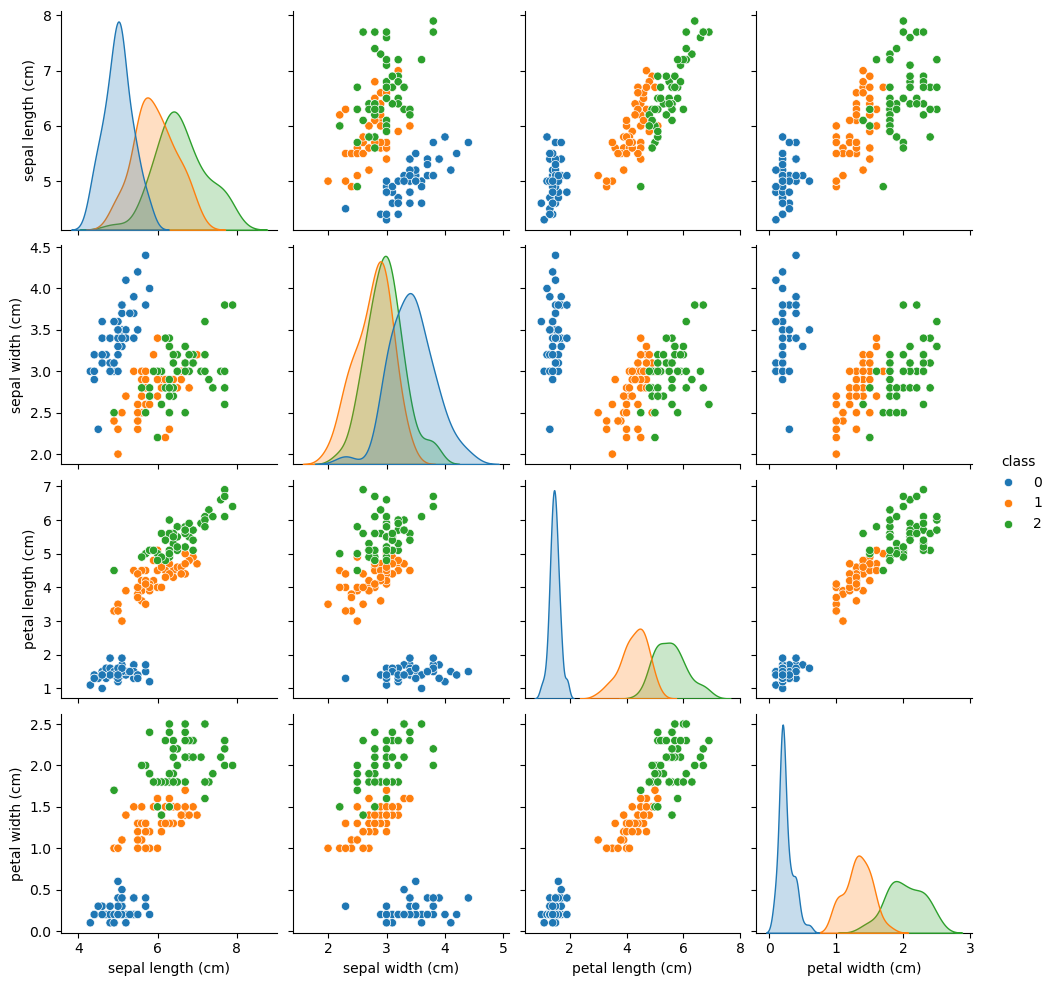

In [5]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

From the plots, we see that class `0` is easily separable from the other two classes, while classes `1` and `2` are sometimes intertwined, especially regarding the "sepal width" feature.

Next, let's see how classical machine learning handles this dataset. 

## 2. Training a Classical Machine Learning Model

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [6]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

/tmp/ipykernel_8520/1930597496.py:4: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 123
/tmp/ipykernel_8520/1930597496.py:6: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  features, labels, train_size

We train a classical Support Vector Classifier from scikit-learn. For the sake of simplicity, we don't tweak any parameters and rely on the default values.

In [7]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

Now we check out how well our classical model performs. We will analyze the scores in the conclusion section.

In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


As can be seen from the scores, the classical SVC algorithm performs very well. Next up, it's time to look at quantum machine learning models.



## 3. Training a Quantum Machine Learning Model

As an example of a quantum model, we'll train a variational quantum classifier (VQC). The VQC is the simplest classifier available in Qiskit Machine Learning and is a good starting point for newcomers to quantum machine learning who have a background in classical machine learning.

But before we train a model, let's examine what comprises the `VQC` class. Two of its central elements are the feature map and ansatz. What these are will now be explained.

Our data is classical, meaning it consists of a set of bits, not qubits. We need a way to encode the data as qubits. This process is crucial if we want to obtain an effective quantum model. We usually refer to this mapping as data encoding, data embedding, or data loading and this is the role of the feature map. While feature mapping is a common ML mechanism, this process of loading data into quantum states does not appear in classical machine learning as that only operates in the classical world.

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

For more information, we direct the reader to the [Quantum Machine Learning Course](https://learn.qiskit.org/course/machine-learning).


## 3.1 Data Encoding Examples

For example, to use the Qiskit [**`EfficientSU2`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) circuit to encode 12 features, would only use 3 qubits:

/opt/conda/envs/qml-env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


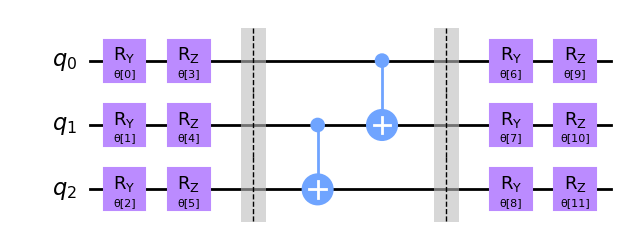

In [9]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(num_qubits=3, reps=1, insert_barriers=True)
circuit.decompose().draw(output='mpl')

Here we encode the datapoint $x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]$ with 12 features, using each of the parameterized gates to encode a different feature.

/tmp/ipykernel_8520/2955382002.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  encode = circuit.bind_parameters(x)
/opt/conda/envs/qml-env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


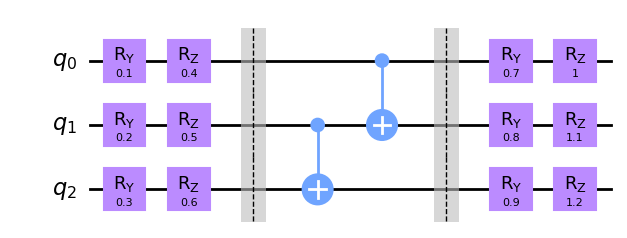

In [10]:
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

encode = circuit.bind_parameters(x)
encode.decompose().draw(output='mpl')

The Qiskit [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) circuit with 3 qubits, only encodes a datapoint of 3 features, despite having 6 parameterized gates:

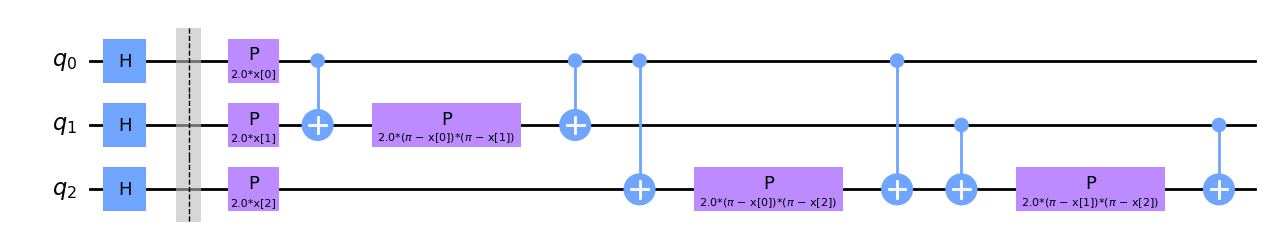

In [11]:
from qiskit.circuit.library import ZZFeatureMap

circuit = ZZFeatureMap(3, reps=1, insert_barriers=True)
circuit.decompose().draw(output='mpl')

/tmp/ipykernel_8520/1598256961.py:3: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  encode = circuit.bind_parameters(x)


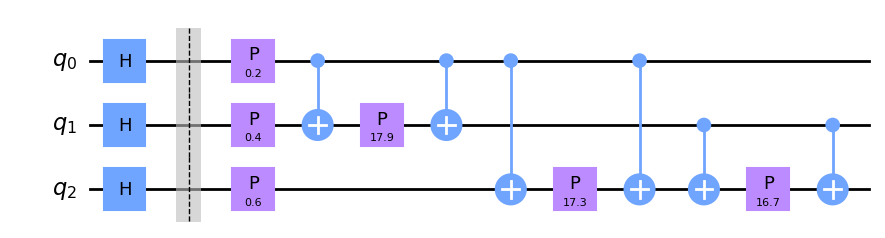

In [12]:
x = [0.1,0.2,0.3]

encode = circuit.bind_parameters(x)
encode.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

### Exercise 1: Data Encoding

Encode the data point $x = (-0.1,0.2)$ using the `ZZFeatureMap` with 4 repetitions and default data mapping function. 


</div>

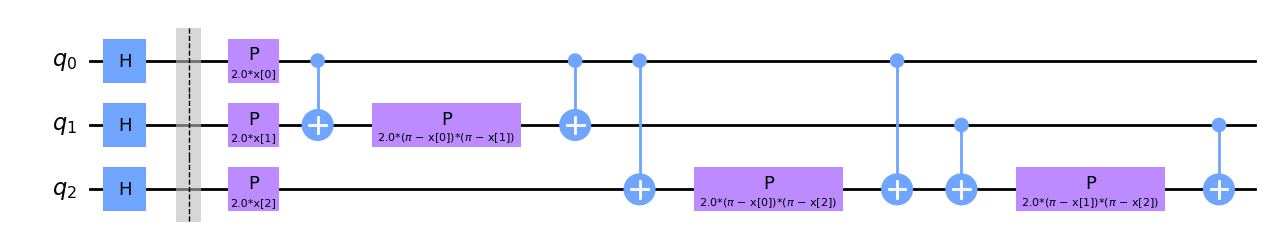

In [13]:
from qiskit.circuit.library import ZZFeatureMap

x = [-0.1,0.2]
# YOUR CODE HERE


# circuit = 
# encode = 
circuit.decompose().draw(output='mpl')

## Encoding our problem dataset

Our choice of feature map will be the ``ZZFeatureMap``. The ``ZZFeatureMap`` is one of the standard feature maps in the Qiskit circuit library. We pass `num_features` as `feature_dimension`, meaning the feature map will have `num_features` or `4` qubits.

We decompose the feature map into its constituent gates to give the reader a flavor of how feature maps may look.

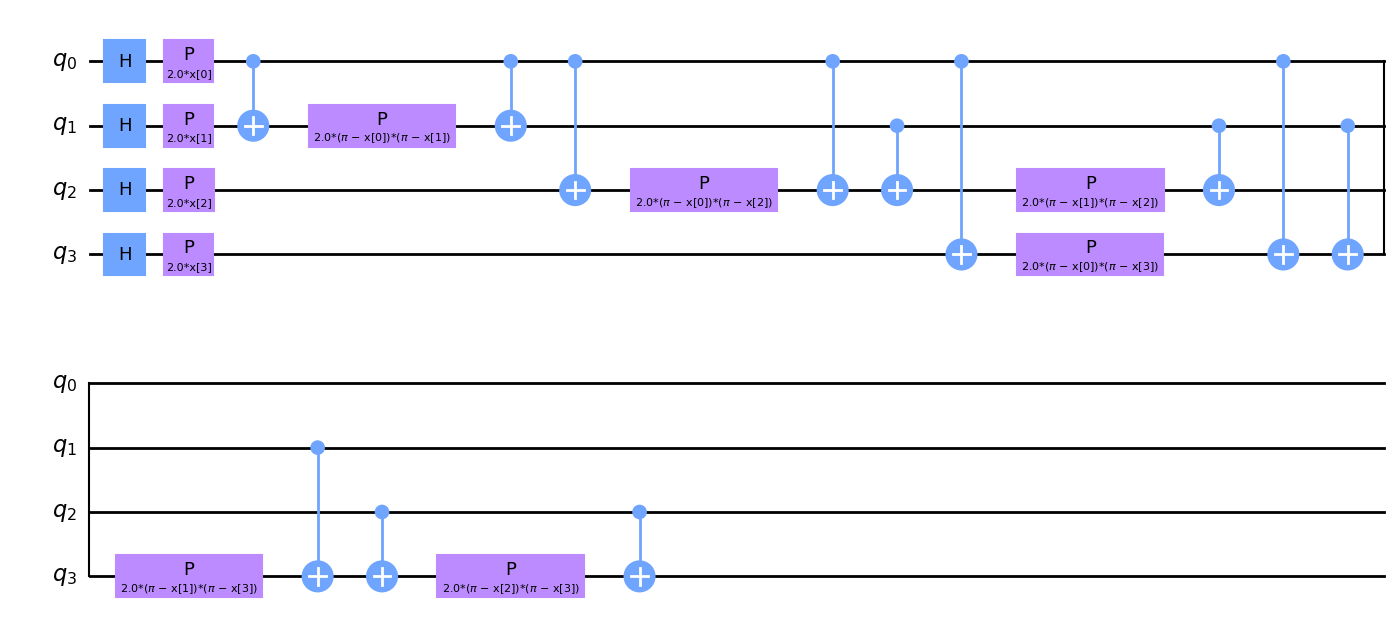

In [14]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

## Defining an Ansatz for our problem

If you look closely at the feature map diagram, you will notice parameters `x[0], ..., x[3]`. These are placeholders for our features.

Now we create and plot our ansatz. Pay attention to the repetitive structure of the ansatz circuit. We define the number of these repetitions using the `reps` parameter.

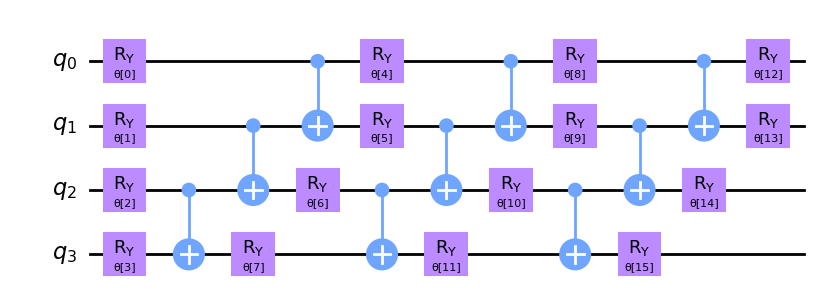

In [15]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

This circuit has 16 parameters named `θ[0], ..., θ[15]`. These are the trainable weights of the classifier.

The variational quantum classifier is a variational algorithm where the measured expectation value is interpreted as the output of a classifier, introduced by mutiple groups in 2018. For a binary classification problem, with input data vectors $\vec{x}_i$ and binary output labels $y_i = \{0,1\}$; for each input data vector, we build a parameterized quantum circuit whose outputs is the quantum state: 
$$ |\psi(\vec{x}_i;\vec{\theta}) \rangle =  U_{W(\vec{\theta})}U_{\phi(\vec{x}_i)}|0 \rangle$$
where $U_{W(\vec{\theta})}$ corresponds to the variational circuit unitary and $U_{\phi(\vec{x}_i)}$ corresponds to the data encoding circuit unitary. After creating and measuring the circuit of $n$ qubits, we are left with a $n$ length bitstring from which we must derive a binary output which will be our classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} \rightarrow \{0, 1\}$. The parity function tends to be used.

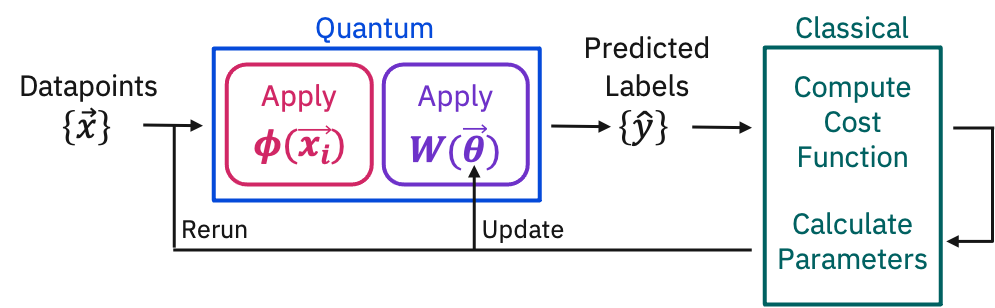


We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.

In [16]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

/tmp/ipykernel_8520/1932753545.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


We will add a callback function called `callback_graph`. `VQC` will call this function for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. The callback will update the plot at each iteration. Note that you can do whatever you want inside a callback function, so long as it has the two-parameter signature we mentioned above.

In [17]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it. 

`VQC` stands for "variational quantum classifier." It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the `sampler` parameter, in this case a `Sampler` instance will be created for you in the way we created it earlier. We created it manually for illustrative purposes only.

Training may take some time. Please, be patient.

In [18]:
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')

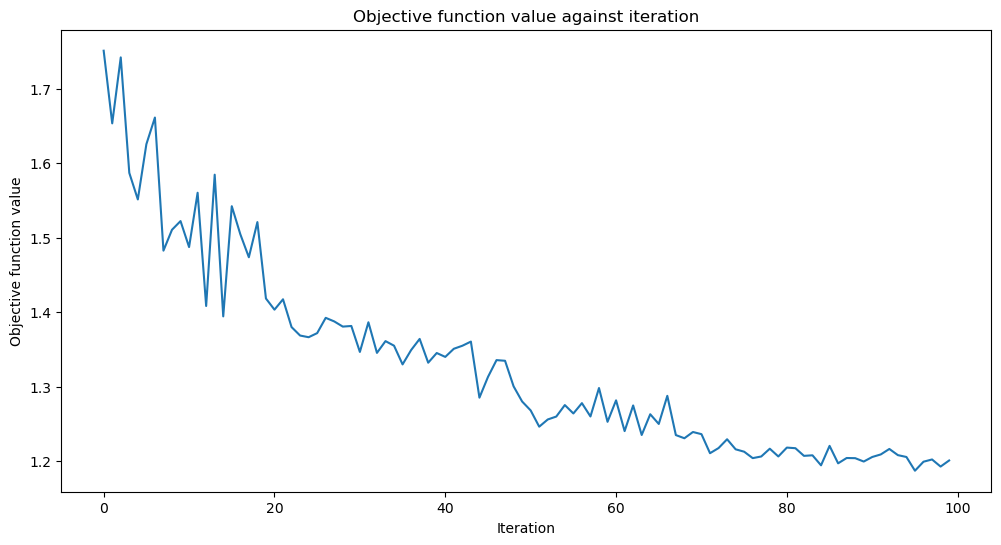

Training time: 35 seconds


In [19]:
import time
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_machine_learning.algorithms.classifiers import VQC

# Use local AerSampler
sampler = AerSampler()

# Set up VQC as before
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Clear objective function history
objective_func_vals = []

# Train model
start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


Let's see how the quantum model performs on the real-life dataset.

In [20]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.71
Quantum VQC on the test dataset:     0.60


As we can see, the scores are high, and the model can be used to predict labels on unseen data.

<div class="alert alert-block alert-success">

### Exercise 2: Try your own ansatz!

Encode the features in any featuremap of you choice and play around with different ansatz of your choice! 
    
- **Doc References:**  
       - **Encoding featuremaps**: [https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits)  
       - **Ansatz**: [https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits)
    
    


</div>

Encoding dataset, feel free to choose any of the standard featuremaps as specified or feel free to make your own! 

/opt/conda/envs/qml-env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


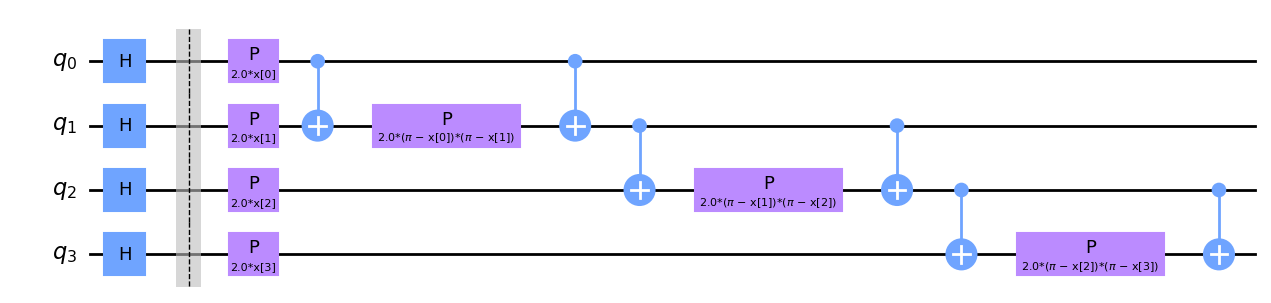

In [21]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, StatePreparation

num_features = features.shape[1]

feature_map_ex = ZZFeatureMap(
    feature_dimension=num_features, reps=1, entanglement="linear", insert_barriers=True
)
feature_map_ex.decompose().draw(output="mpl", fold=20)

Setting ansatz for the routine: Feel free to select from the selection of circuits in the doc link above or make your own!

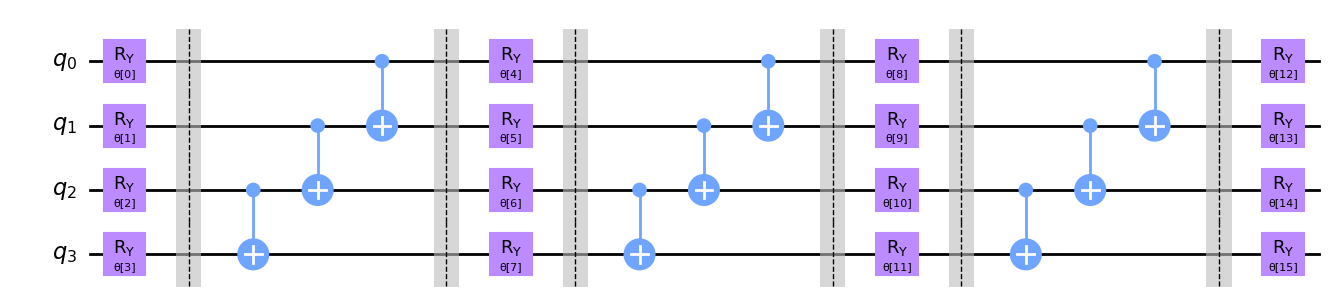

In [22]:
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ExcitationPreserving, PauliTwoDesign, TwoLocal, NLocal

ansatz_ex = RealAmplitudes(num_qubits=num_features, reps=3, insert_barriers=True)
ansatz_ex.decompose().draw(output="mpl", fold=20)

Feel free to choose optimizers from the list here! [https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers)

In [23]:
from qiskit.algorithms.optimizers import COBYLA, SPSA, L_BFGS_B, NELDER_MEAD, UMDA, TNC

optimizer_ex = COBYLA(maxiter=100, tol=1e-4)

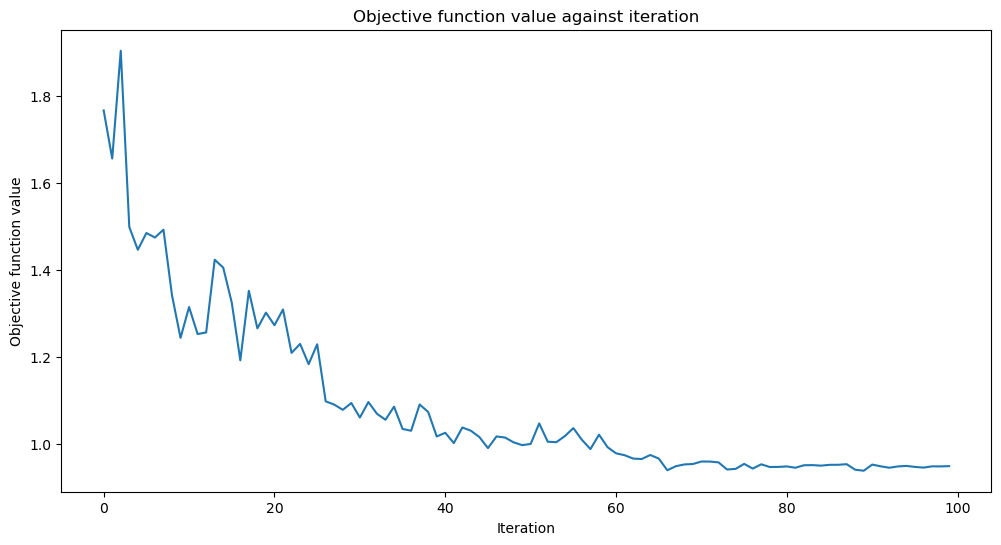

Training time: 33 seconds


In [24]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler

# Create a local sampler using Aer
sampler = AerSampler()

# Clear objective value history
objective_func_vals = []

# Initialize VQC with AerSampler
vqc_ex = VQC(
    feature_map=feature_map_ex,
    ansatz=ansatz_ex,
    optimizer=optimizer_ex,
    callback=callback_graph,
    sampler=sampler,  # 👈 use Aer here
)

# Fit model
start = time.time()
vqc_ex.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [25]:
train_score_q4_ex = vqc_ex.score(train_features, train_labels)
test_score_q4_ex = vqc_ex.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4_ex:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_ex:.2f}")

Quantum VQC on the training dataset: 0.93
Quantum VQC on the test dataset:     0.87




Now let's see what we can tune to get even better models.

- The key components are the feature map and the ansatz. You can tweak parameters. In our case, you may change the `reps` parameter that specifies how repetitions of a gate pattern we add to the circuit. Larger values lead to more entanglement operations and more parameters. Thus, the model can be more flexible, but the higher number of parameters also adds complexity, and training such a model usually takes more time. Furthermore, we may end up overfitting the model. You can try the other feature maps and ansatzes available in the [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits), or you can come up with custom circuits.
- You may try other optimizers. Qiskit contains a bunch of them. Some of them are gradient-free, others not. If you choose a gradient-based optimizer, e.g., `L_BFGS_B`, expect the training time to increase. Additionally to the objective function, these optimizers must evaluate the gradient with respect to the training parameters, which leads to an increased number of circuit executions per iteration.
- Another option is to randomly (or deterministically) sample `initial_point` and fit the model several times.

But what if a dataset contains more features than a modern quantum computer can handle? Recall, in this example, we had the same number of qubits as the number of features in the dataset, but this may not always be the case.



## 4. Reducing the Number of Features

In this section, we reduce the number of features in our dataset and train our models again. We'll move through faster this time as the steps are the same except for the first, where we apply a PCA transformation. 

We transform our four features into two features only. This dimensionality reduction is for educational purposes only. As you saw in the previous section, we can train a quantum model using all four features from the dataset.

Now, we can easily plot these two features on a single figure.

<Axes: >

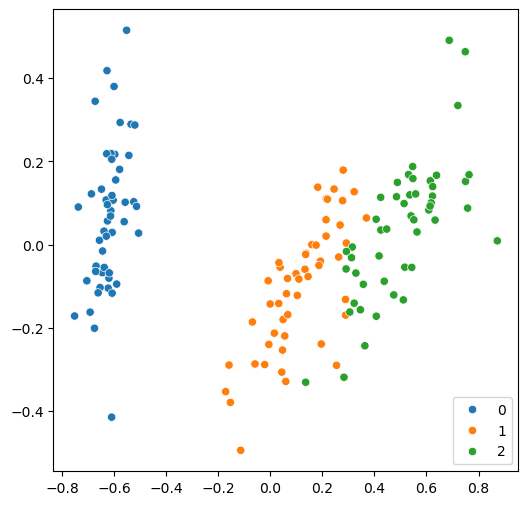

In [26]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

As usual, we split the dataset first, then fit a classical model.

In [27]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


/tmp/ipykernel_8520/1215845172.py:2: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  features, labels, train_size=0.8, random_state=algorithm_globals.random_seed


The results are still good but slightly worse compared to the initial version. Let's see how a quantum model deals with them. As we now have two qubits, we must recreate the feature map and ansatz.

/opt/conda/envs/qml-env/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


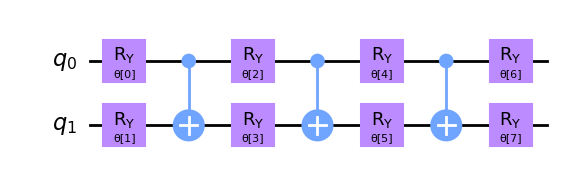

In [28]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw("mpl")

We also reduce the maximum number of iterations we run the optimization process for, as we expect it to converge faster because we now have fewer qubits.

In [29]:
from qiskit.algorithms.optimizers import COBYLA, SPSA, L_BFGS_B, NELDER_MEAD, UMDA, TNC

optimizer = COBYLA(maxiter=100)

Now we construct a quantum classifier from the new parameters and train it. 

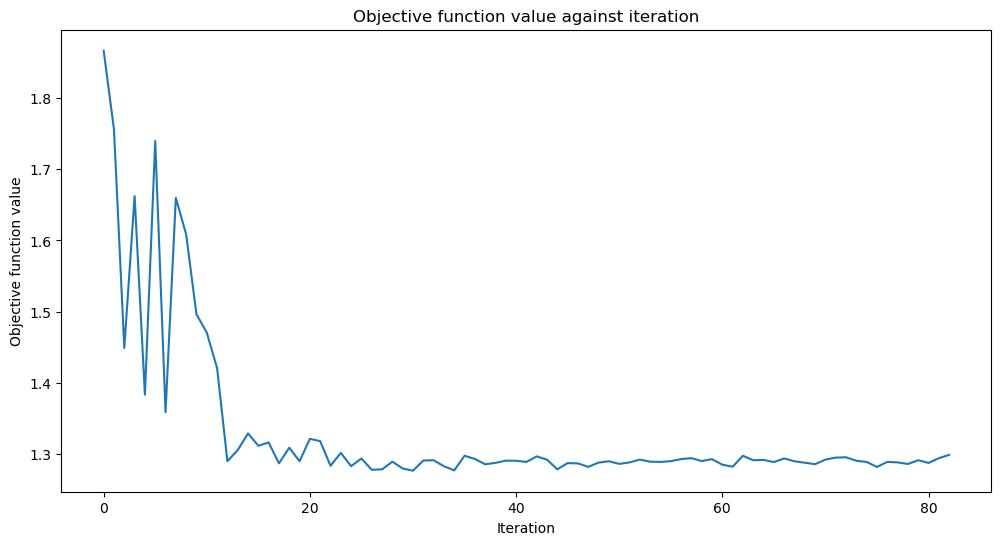

Training time: 23 seconds


In [30]:
from qiskit_aer.primitives import Sampler as AerSampler
import time
import matplotlib.pyplot as plt

# Create a Sampler using Aer backend
sampler = AerSampler()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# Clear objective value history
objective_func_vals = []

# Set figure size for plotting
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [31]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.55
Quantum VQC on the test dataset using RealAmplitudes:     0.63


Well, the scores are higher than a fair coin toss but could be better. The objective function is almost flat towards the end, meaning increasing the number of iterations won't help, and model performance will stay the same. Let's see what we can do with another ansatz.

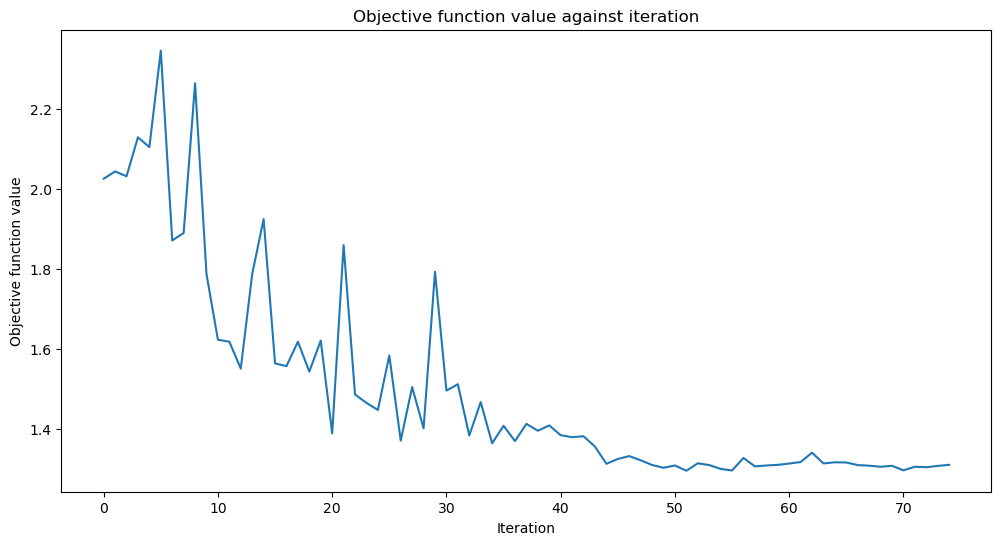

Training time: 22 seconds


In [32]:
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA
import time
import matplotlib.pyplot as plt

num_qubits = num_features  # Assuming num_features is defined

# Prepare ansatz and optimizer
ansatz = EfficientSU2(num_qubits=num_qubits, reps=3)
optimizer = COBYLA(maxiter=75)

# Use Aer simulator backend
sampler = AerSampler()

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# set plot size if needed
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [33]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.57
Quantum VQC on the test dataset using EfficientSU2:     0.60


The scores are better than in the previous setup. Perhaps if we had used more iterations, we could do even better.

## 5. Conclusion

In this tutorial, we have built two classical and three quantum machine learning models. Let's print an overall table with our results.

In [34]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.71 |       0.60
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, EfficientSU2   |       0.57 |       0.60
VQC, 2 features, RealAmplitudes |       0.55 |       0.63


Unsurprisingly, the classical models perform better than their quantum counterparts, but classical ML has come a long way, and quantum ML has yet to reach that level of maturity. As we can see,  we achieved the best results using a classical support vector machine. But the quantum model trained on four features was also quite good. When we reduced the number of features, the performance of all models went down as expected. So, if resources permit training a model on a full-featured dataset without any reduction, you should train such a model. If not, you may expect to compromise between dataset size, training time, and score.

Another observation is that even a simple ansatz change can lead to better results. The two-feature model with the `EfficientSU2` ansatz performs better than the one with `RealAmplitudes`. That means the choice of hyperparameters plays the same critical role in quantum ML as in classical ML, and searching for optimal hyperparameters may take a long time. You may apply the same techniques we use in classical ML, such as random/grid or more sophisticated approaches.

We hope this brief tutorial helps you to take the leap from classical to quantum ML.

In [35]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright